In [1]:
import numpy as np
from pathlib import Path
from src.scripts.plot_gps import load_gps_data, plot_gps_data, save_gps_fig

import logging
logging.getLogger().setLevel(logging.FATAL)

In [2]:
trip = 'Trip071'
outdir = Path(trip)
outdir.mkdir(exist_ok=True)

path = Path(f'/dataset/{trip}')
ts, gps_coords = load_gps_data(path)
gps_coords

array([[ 63.23965966,   9.50231012, 376.335     ],
       [ 63.23965889,   9.50231319, 376.325     ],
       [ 63.23965811,   9.50231639, 376.315     ],
       ...,
       [ 63.23995541,   9.56178662, 379.61      ],
       [ 63.23995541,   9.56178662, 379.61      ],
       [ 63.23995541,   9.56178664, 379.605     ]])

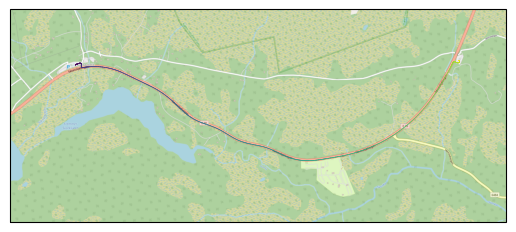

In [3]:
fig, world_coords, px_q = plot_gps_data(ts, gps_coords)
save_gps_fig(fig, outdir / 'fig.png')
px_q = dict(px_q)

In [4]:
# Transform to NED and Carla coordinates
import pymap3d
alt = 0
gps_origin = np.mean(gps_coords, axis=0)[:2]
N, E, D = pymap3d.geodetic2ned(gps_coords[:, 0], gps_coords[:, 1], alt, *gps_origin, alt)

carla_lat = N / 111324.60662786
carla_lon = E / 111319.490945

# carla_origin = (0, 0, 0)
# carla_lat, carla_lon, _ = pymap3d.ned2geodetic(N, E, alt, *carla_origin)
# carla_N = carla_lat * 111324.60662786
# carla_E = carla_lon * 111319.490945
# err_n=N-carla_N
# err_e=E-carla_E
# print('Maximum NS error:', np.abs(err_n).max())
# print('Maximum EW error:', np.abs(err_e).max())

# corr_n = np.mean(carla_N / N)
# corr_e = np.mean(carla_E / E)
# print('Correction coefficients:', corr_n, corr_e)
# carla_lat /= corr_n
# carla_lon /= corr_e
# carla_N = carla_lat * 111324.60662786
# carla_E = carla_lon * 111319.490945
# err_n=N-carla_N
# err_e=E-carla_E
# print('Maximum NS error:', np.abs(err_n).max())
# print('Maximum EW error:', np.abs(err_e).max())

In [5]:
from PIL import Image
fig_image = Image.open(outdir / 'fig.png')
if (outdir / 'plan.png').exists():
    image = Image.open(outdir / 'plan.png')
else:
    image = fig_image
px_coords = px_q[image.size]

In [6]:
data = np.array(image)
pink = np.transpose(np.where(np.all(data == (255, 0, 255, 255), axis=-1)))

In [7]:
def find_clusters(points):
    points = set(map(tuple, points))
    clusters = []
    while points:
        point = y, x = points.pop()
        neighbors = [
            (y + i, x + j)
            for i in [-1, 0, 1]
            for j in [-1, 0, 1]
        ]
        
        matching_clusters = []
        for cluster in clusters:
            for neighbor in neighbors:
                if neighbor in cluster:
                    matching_clusters.append(cluster)
                    break
        
        if not matching_clusters:
            clusters.append({ point })
        else:
            main, *to_merge = matching_clusters
            main.add(point)
            for other in to_merge:
                main.update(other)
                other.clear()
            if to_merge:
                clusters = list(filter(None, clusters))
    
    return [np.array(list(cluster)) for cluster in clusters]

pink_clusters = find_clusters(pink)

pink_centers = []
for cluster in pink_clusters:
    y, x = np.mean(cluster, axis=0)
    pink_centers.append((x, y))

In [8]:
iplan = sorted([
    np.argmin(np.sqrt(((px_coords - wp) ** 2).sum(axis=1)))
    for wp in pink_centers
])
iplan.insert(0, 0)
iplan.append(len(px_coords) - 2)

In [9]:
# Fill inn with waypoints every 50 meters
import itertools
# print(iplan)
NE = np.vstack((N, E)).T
# print('NE', NE.shape)
NE_diff = NE[1:] - NE[:-1]
# print('NE_diff', NE_diff.shape)
NE_distances = np.linalg.norm(NE_diff, axis=1)
# print('NE_dist', NE_distances.shape)
cum_distances = np.cumsum(NE_distances)
# print('cum_dist', cum_distances[iplan])
distances = cum_distances[iplan[1:]] - cum_distances[iplan[:-1]]
# print('dist', distances)
missing_wps = (distances // 50).astype(int)
print(missing_wps)
for num, dist, idx, i in reversed(list(zip(missing_wps, distances, iplan, itertools.count()))):
    if not num:
        continue
    spacing = dist / (num + 1)
    print(f'insert {num} after i={i}, idx={idx} with spacing {spacing:.2f}')
    cur_dist = 0
    prev_cur_dist = 0
    for j in range(num):
        while cur_dist < (j+1) * spacing and idx + 1 < NE.shape[0]:
            cur_dist += NE_distances[idx]
            idx += 1
        print(f'  - found point at {idx} dist {cur_dist - prev_cur_dist:.2f}')
        iplan.insert(i+1, idx)
        i += 1
        prev_cur_dist = cur_dist


# Check if it worked
vectors = NE[iplan[1:]] - NE[iplan[:-1]]
distances = np.linalg.norm(vectors, axis=1)
distances[distances > 50]

[70]
insert 70 after i=0, idx=0 with spacing 49.93
  - found point at 195 dist 50.10
  - found point at 427 dist 50.16
  - found point at 468 dist 50.41
  - found point at 501 dist 49.36
  - found point at 531 dist 52.04
  - found point at 557 dist 48.07
  - found point at 586 dist 50.18
  - found point at 615 dist 49.95
  - found point at 641 dist 50.32
  - found point at 667 dist 50.00
  - found point at 692 dist 49.62
  - found point at 716 dist 49.58
  - found point at 741 dist 49.51
  - found point at 766 dist 50.52
  - found point at 791 dist 50.64
  - found point at 815 dist 48.40
  - found point at 840 dist 50.76
  - found point at 865 dist 50.16
  - found point at 891 dist 49.17
  - found point at 917 dist 51.33
  - found point at 943 dist 49.80
  - found point at 968 dist 50.03
  - found point at 991 dist 49.20
  - found point at 1016 dist 50.98
  - found point at 1039 dist 49.81
  - found point at 1062 dist 50.14
  - found point at 1086 dist 49.54
  - found point at 1109 dis

array([50.37653578, 52.01111339, 50.16342006, 50.31717015, 50.50741789,
       50.62785881, 50.74788781, 50.15305408, 51.3132494 , 50.00056795,
       50.98132405, 50.10634126, 50.82725556, 51.1087311 , 50.51661214,
       50.48668662, 51.74386732, 50.44350377, 50.24706844, 51.53465279,
       50.09139016, 51.16790834, 50.37375055, 50.00630968, 50.54902492,
       51.22058084, 51.80711171, 51.54340754, 52.13860743])

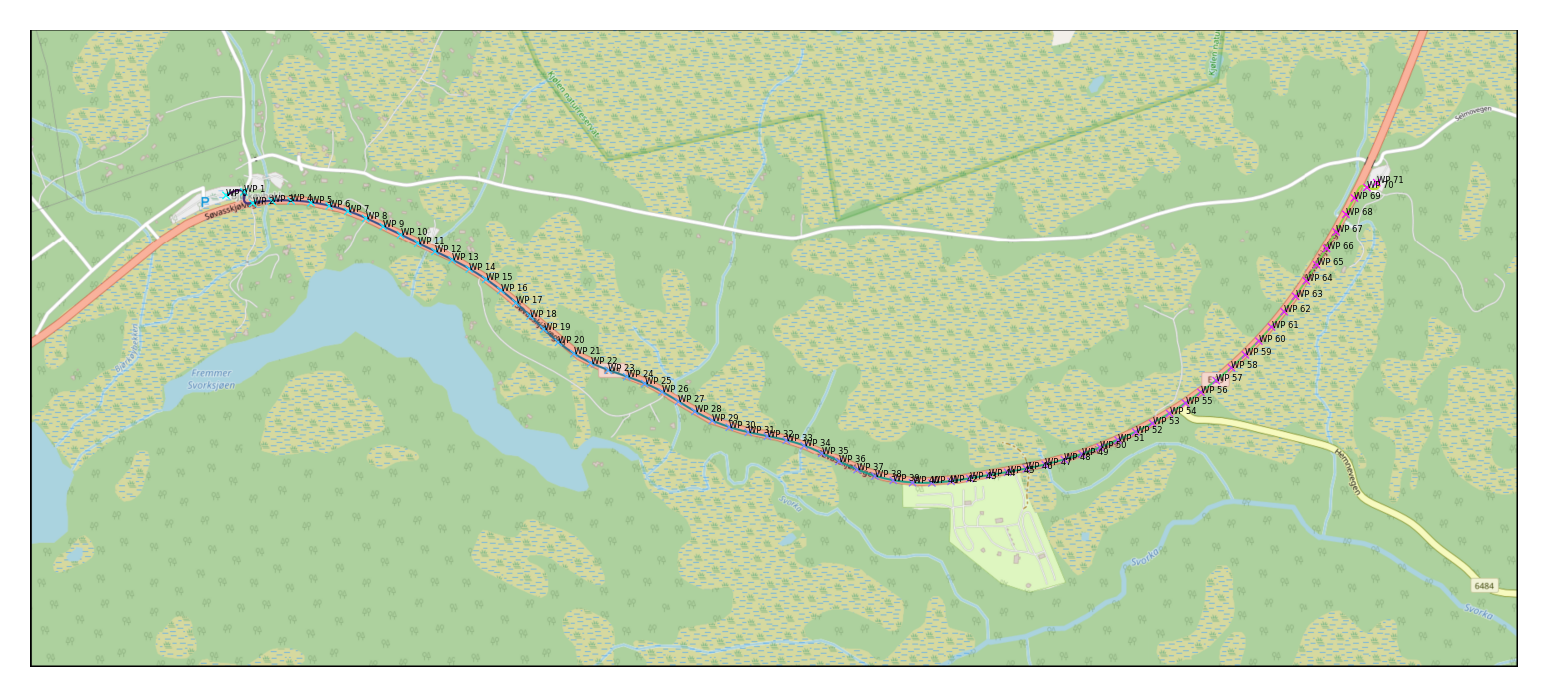

In [10]:
from matplotlib import pyplot as plt
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1)
ax.imshow(fig_image)
ax.set_axis_off()
ax.scatter(px_coords[iplan, 0], px_coords[iplan, 1], s=3, c=np.linspace(0, 1, len(iplan)), cmap='cool', marker='x', linewidths=0.3)
for i, idx in enumerate(iplan):
    ax.text(*px_coords[idx], f'WP {i}', fontsize=2)
fig.savefig(outdir / 'plan_annotated.png', dpi=1000, bbox_inches='tight', pad_inches=0)

In [11]:
with open(outdir / 'plan.csv', 'wt') as csv:
    csv.write('idx,lat,lon,n,e,d,carla_lat,carla_lon\n')
    csv.writelines([
        f'-1,{gps_origin[0]},{gps_origin[1]},0,0,0,0,0\n'
    ])
    csv.writelines([
        f'{idx},{gps_coords[idx, 0]},{gps_coords[idx, 1]},{N[idx]},{E[idx]},{D[idx]},{carla_lat[idx]},{carla_lon[idx]}\n'
        for idx in iplan
    ])